<a href="https://colab.research.google.com/github/raghavadevarajeurs/DeepLearning/blob/main/Assignment5/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import colab
  !pip install --upgrade pip
except:
  pass

     |████████████████████████████████| 1.5MB 15.7MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [2]:
!pip install -q -U tfx

     |████████████████████████████████| 2.3 MB 19.9 MB/s 
     |████████████████████████████████| 17.7 MB 84 kB/s 
     |████████████████████████████████| 1.7 MB 61.2 MB/s 
     |████████████████████████████████| 2.9 MB 71.2 MB/s 
     |████████████████████████████████| 1.2 MB 68.0 MB/s 
     |████████████████████████████████| 9.0 MB 59.5 MB/s 
     |████████████████████████████████| 103 kB 62.9 MB/s 
     |████████████████████████████████| 400 kB 67.8 MB/s 
     |████████████████████████████████| 147 kB 76.5 MB/s 
     |████████████████████████████████| 1.5 MB 72.9 MB/s 
     |████████████████████████████████| 2.2 MB 64.4 MB/s 
     |████████████████████████████████| 54 kB 1.2 MB/s 
     |████████████████████████████████| 1.4 MB 48.8 MB/s 
     |████████████████████████████████| 89 kB 10.6 MB/s 
     |████████████████████████████████| 56 kB 5.5 MB/s 
     |████████████████████████████████| 61 kB 9.7 MB/s 
     |████████████████████████████████| 2.2 MB 62.4 MB/s 
     |████████████████

In [3]:
!pip install tensorflow==1.2

ERROR: Could not find a version that satisfies the requirement tensorflow==1.2
ERROR: No matching distribution found for tensorflow==1.2


In [4]:
!apt-get -qq install -y libfluidsynth1

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [1]:
import os
import pprint
import tempfile
import urllib

import absl
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from tfx.components import CsvExampleGen
from tfx.components import Evaluator
from tfx.components import ExampleValidator
from tfx.components import Pusher
from tfx.components import ResolverNode
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Trainer
from tfx.components import Transform
from tfx.components.base import executor_spec
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing
from tfx.utils.dsl_utils import external_input


%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

In [2]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.4.1
TFX version: 0.29.0


In [3]:
# This is the root directory for your TFX pip package installation.
_tfx_root = tfx.__path__[0]

# This is the directory containing the TFX Chicago Taxi Pipeline example.
_taxi_root = os.path.join(_tfx_root, 'examples/chicago_taxi_pipeline')

# This is the path where your model will be pushed for serving.
_serving_model_dir = os.path.join(
    tempfile.mkdtemp(), 'serving_model/taxi_simple')

# Set up logging.
absl.logging.set_verbosity(absl.logging.INFO)

In [4]:
_data_root = tempfile.mkdtemp(prefix='tfx-data')
DATA_PATH = 'https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv'
_data_filepath = os.path.join(_data_root, "data.csv")
urllib.request.urlretrieve(DATA_PATH, _data_filepath)

('/tmp/tfx-datavun_95gc/data.csv', <http.client.HTTPMessage at 0x7f373c01aa50>)

In [5]:
!head {_data_filepath}

pickup_community_area,fare,trip_start_month,trip_start_hour,trip_start_day,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,pickup_census_tract,dropoff_census_tract,payment_type,company,trip_seconds,dropoff_community_area,tips
,12.45,5,19,6,1400269500,,,,,0.0,,,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,0,,0.0
,0,3,19,5,1362683700,,,,,0,,,Unknown,Chicago Elite Cab Corp.,300,,0
60,27.05,10,2,3,1380593700,41.836150155,-87.648787952,,,12.6,,,Cash,Taxi Affiliation Services,1380,,0.0
10,5.85,10,1,2,1382319000,41.985015101,-87.804532006,,,0.0,,,Cash,Taxi Affiliation Services,180,,0.0
14,16.65,5,7,5,1369897200,41.968069,-87.721559063,,,0.0,,,Cash,Dispatch Taxi Affiliation,1080,,0.0
13,16.45,11,12,3,1446554700,41.983636307,-87.723583185,,,6.9,,,Cash,,780,,0.0
16,32.05,12,1,1,1417916700,41.953582125,-87.72345239,,,15.4,,,Cash,,1200,,0.0
30,38.45,10,10,5,1444301100,41.839086906,-87.714003807,,,14.6,,,Cash,,2580,,0.0
11,14.65,1,1,3,1358

In [6]:
context = InteractiveContext()

In [7]:
example_gen = CsvExampleGen(input=external_input(_data_root))
context.run(example_gen)

Instructions for updating:
external_input is deprecated, directly pass the uri to ExampleGen.
INFO:absl:Running driver for CsvExampleGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:select span and version = (0, None)
INFO:absl:latest span and version = (0, None)
INFO:absl:Running executor for CsvExampleGen
INFO:absl:Generating examples.


INFO:absl:Processing input csv data /tmp/tfx-datavun_95gc/* to TFExample.
INFO:absl:Examples generated.
INFO:absl:Running publisher for CsvExampleGen
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1
        type_id: 5
        uri: "/tmp/tfx-interactive-2021-04-18T08_26_52.775864-j6h70620/CsvExampleGen/examples/1"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:1922812,xor_checksum:1618734378,sum_checksum:1618734378"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            string_value: "0"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [8]:
artifact = example_gen.outputs['examples'].get()[0]
print(artifact.split_names, artifact.uri)

["train", "eval"] /tmp/tfx-interactive-2021-04-18T08_26_52.775864-j6h70620/CsvExampleGen/examples/1


In [10]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [11]:
!kaggle competitions download -c nyc-taxi-trip-duration

  0% 0.00/2.49M [00:00<?, ?B/s]
100% 2.49M/2.49M [00:00<00:00, 135MB/s]
 78% 49.0M/62.9M [00:00<00:00, 60.8MB/s]
100% 62.9M/62.9M [00:00<00:00, 72.1MB/s]
 44% 9.00M/20.3M [00:00<00:00, 40.0MB/s]
100% 20.3M/20.3M [00:00<00:00, 66.9MB/s]


In [13]:
import zipfile
zip = '/content/train.zip'
zip1 = zipfile.ZipFile(zip, 'r')
zip1.extractall('/content/train')
zip1.close()

In [25]:
import tensorflow as tf
from tensorflow.keras.experimental import WideDeepModel, LinearModel
import keras
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic

In [18]:
df = pd.read_csv('/content/train/train.csv')[:15000]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  15000 non-null  object 
 1   vendor_id           15000 non-null  int64  
 2   pickup_datetime     15000 non-null  object 
 3   dropoff_datetime    15000 non-null  object 
 4   passenger_count     15000 non-null  int64  
 5   pickup_longitude    15000 non-null  float64
 6   pickup_latitude     15000 non-null  float64
 7   dropoff_longitude   15000 non-null  float64
 8   dropoff_latitude    15000 non-null  float64
 9   store_and_fwd_flag  15000 non-null  object 
 10  trip_duration       15000 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 1.3+ MB


In [21]:
df_features = df.copy()
df_features['pickup_datetime'] = pd.to_datetime(df_features['pickup_datetime'])
df_features['month'] = df_features['pickup_datetime'].dt.month
df_features['day'] = df_features['pickup_datetime'].dt.day
df_features['hour'] = df_features['pickup_datetime'].dt.hour
df_features['distance'] = df_features.apply(lambda x: geodesic((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).miles, axis=1)
df_features['trip_duration'] = df_features['trip_duration'] / 60.
df_features.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day,hour,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,7.583333,3,14,17,0.933406
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,11.050000,6,12,0,1.123849
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,35.400000,1,19,11,3.964154
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,7.150000,4,6,19,0.921886
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,7.250000,3,26,13,0.737591
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,7.383333,1,30,22,0.683275
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,5.683333,6,17,22,0.824764
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,25.850000,5,21,7,3.553009
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,4.250000,5,27,23,0.815587
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,20.416667,3,10,21,3.178194


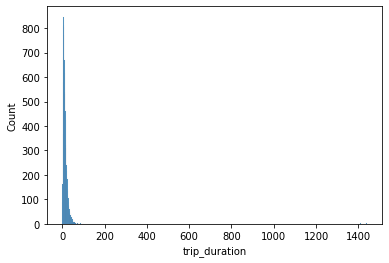

In [29]:
ax = sns.histplot(data=df_features, x="trip_duration")

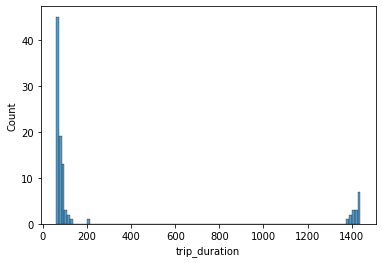

In [33]:
ax = sns.histplot(data=df_features[df_features['trip_duration'] > 60], x="trip_duration")

## Train

In [34]:
label_col = 'trip_duration'

X_deep = df_features[['passenger_count', 'distance']].to_numpy()
X_wide = df_features[['month', 'day']].to_numpy()
y = df_features[[label_col]].to_numpy()

In [35]:
epochs = 10

In [36]:
linear_model = LinearModel()
linear_model.compile('adagrad', 'mse')
linear_model.fit(X_wide, y, epochs)
dnn_model = keras.Sequential([keras.layers.Dense(units=2)])
dnn_model.compile('rmsprop', 'mse')
dnn_model.fit(X_deep, y, epochs)
combined_model = WideDeepModel(linear_model, dnn_model)
combined_model.compile(optimizer='adam', loss='mse')
history = combined_model.fit([X_wide, X_deep], y, epochs)

1500/1500 [==============================] - 3s 2ms/step - loss: 1560.7067


## TFX Interactive pipeline

In [37]:
!mkdir -p /content/temp
!head -n 50000 {'/content/train/train.csv'} > {'/content/temp/train.csv'}

In [38]:
TRAIN_DIR = '/content/temp'

In [40]:
example_gen = CsvExampleGen(input=external_input(TRAIN_DIR))
context.run(example_gen)

INFO:absl:Running driver for CsvExampleGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:select span and version = (0, None)
INFO:absl:latest span and version = (0, None)
INFO:absl:Running executor for CsvExampleGen
INFO:absl:Generating examples.
INFO:absl:Processing input csv data /content/temp/* to TFExample.
INFO:absl:Examples generated.
INFO:absl:Running publisher for CsvExampleGen
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 2
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 2
        type_id: 5
        uri: "/tmp/tfx-interactive-2021-04-18T08_26_52.775864-j6h70620/CsvExampleGen/examples/2"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:6876054,xor_checksum:1618735298,sum_checksum:1618735298"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            string_value: "0"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [41]:
# Get the URI of the output artifact representing the training examples, which is a directory
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Iterate over the first 3 records and decode them.
for tfrecord in dataset.take(3):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  pp.pprint(example)

features {
  feature {
    key: "dropoff_datetime"
    value {
      bytes_list {
        value: "2016-03-14 17:32:30"
      }
    }
  }
  feature {
    key: "dropoff_latitude"
    value {
      float_list {
        value: 40.765602111816406
      }
    }
  }
  feature {
    key: "dropoff_longitude"
    value {
      float_list {
        value: -73.96463012695312
      }
    }
  }
  feature {
    key: "id"
    value {
      bytes_list {
        value: "id2875421"
      }
    }
  }
  feature {
    key: "passenger_count"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "pickup_datetime"
    value {
      bytes_list {
        value: "2016-03-14 17:24:55"
      }
    }
  }
  feature {
    key: "pickup_latitude"
    value {
      float_list {
        value: 40.76793670654297
      }
    }
  }
  feature {
    key: "pickup_longitude"
    value {
      float_list {
        value: -73.9821548461914
      }
    }
  }
  feature {
    key: "store_and_fwd_flag"

In [42]:
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples'])
context.run(statistics_gen)

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Running driver for StatisticsGen
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Running executor for StatisticsGen
INFO:absl:Generating statistics for split train.
INFO:absl:Statistics for split train written to /tmp/tfx-interactive-2021-04-18T08_26_52.775864-j6h70620/StatisticsGen/statistics/3/Split-train.
INFO:absl:Generating statistics for split eval.
INFO:absl:Statistics for split eval written to /tmp/tfx-interactive-2021-04-18T08_26_52.775864-j6h70620/StatisticsGen/statistics/3/Split-eval.
INFO:absl:Running publisher for StatisticsGen
INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: StatisticsGen
    execution_id: 3
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 3
        type_id: 7
        uri: "/tmp/tfx-interactive-2021-04-18T08_26_52.775864-j6h70620/StatisticsGen/statistics/3"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "0.29.0"
          }
        }
        state: LIVE
        , artifact_type: id: 7
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [43]:
context.show(statistics_gen.outputs['statistics'])